### Loading GAMS magic
The **gams_magic** Python package is loaded in order to access GAMS line and cell magics

In [1]:
%load_ext gams_magic

### Symbol declaration in GAMS
The cell magic **%%gams** is used to write GAMS code declaring the Sets and Parameters used by the model

In [2]:
%%gams
Set date   'date'
    symbol 'stock symbol';
Alias (d,date), (s,symbol);

### Loading the price data
The price data is provided from a CSV file located on the web. The Python package **pandas** is used to load the data. 

In [3]:
import pandas as pd
url="https://github.com/daveh19/pydataberlin2017/raw/master/notebooks/dowjones2016.csv"
price=pd.read_csv(url)
price.head()

,date,symbol,price
0,2016-01-04,AAPL,105.349998
1,2016-01-04,AXP,67.589996
2,2016-01-04,BA,140.500000
3,2016-01-04,CAT,67.989998
4,2016-01-04,CSCO,26.410000


**%gams_push** is used to push the data from Python to GAMS in order to fill the GAMS Sets **date** and **symbol** as well as the GAMS Parameter 'price'.

In [4]:
%gams Parameter price(date<,symbol<) 'price of stock on date';
%gams_push price

In [5]:
%gams_pull -d price date symbol
price.head()

,date,symbol,value
0,2016-01-04,AAPL,105.349998
1,2016-01-04,AXP,67.589996
2,2016-01-04,BA,140.500000
3,2016-01-04,CAT,67.989998
4,2016-01-04,CSCO,26.410000


The mean price per stock is calculated in GAMS.

In [6]:
%gams Parameter avgprice(symbol) 'average price of stock'; avgprice(s) = sum(d, price(d,s))/card(d);
%gams_pull -d avgprice
avgprice.head()

,symbol,value
0,AAPL,104.604008
1,AXP,63.793333
2,BA,133.111508
3,CAT,78.698016
4,CSCO,28.789683


The averages can be used in order to calculate weights.

In [7]:
%gams Parameter weight(symbol) 'weight of stock'; weight(symbol) = avgprice(symbol)/sum(s, avgprice(s));
%gams_pull -d weight
weight.head()

,symbol,value
0,AAPL,0.039960
1,AXP,0.024370
2,BA,0.050850
3,CAT,0.030063
4,CSCO,0.010998


Compute the contributions using weight and price

In [8]:
%gams Parameter contribution(d,s); contribution(d,s) = weight(s)*price(d,s);
%gams_pull -d contribution
contribution.head()

,date,symbol,value
0,2016-01-04,AAPL,4.209752
1,2016-01-04,AXP,1.647143
2,2016-01-04,BA,7.144396
3,2016-01-04,CAT,2.044007
4,2016-01-04,CSCO,0.290455


Compute index values

In [9]:
%gams Parameter index(date) 'Dow Jones index'; index(d) = sum(s, contribution(d,s));
%gams_pull -d index
index.head()

,date,value
0,2016-01-04,100.572929
1,2016-01-05,100.511422
2,2016-01-06,99.014207
3,2016-01-07,96.606033
4,2016-01-08,95.685461


Create a plot showing the symbol and index values over time

<IPython.core.display.Javascript object>


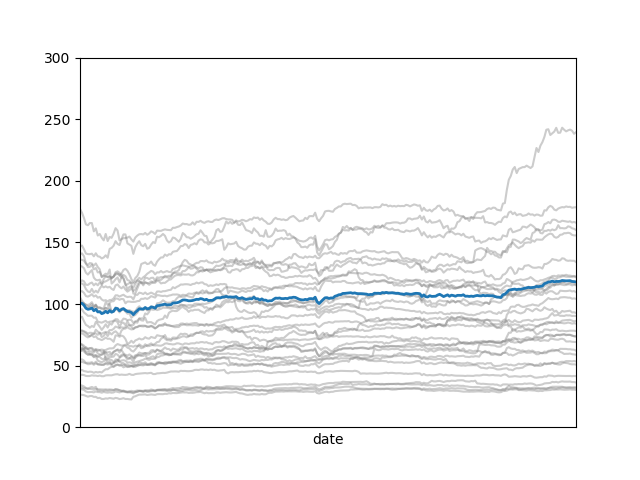

In [10]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
price.groupby('symbol').plot(x='date', y='value', ax=ax, alpha=0.4, color='grey', legend=False, ylim=(0,300), xticks=[])
index.plot(x='date', y='value', ax=ax, linewidth=2, legend=False)

<IPython.core.display.Javascript object>


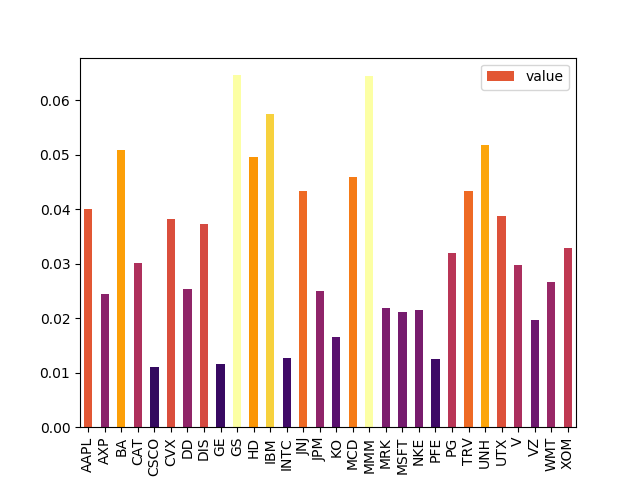

In [11]:
sMap = matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(0, weight['value'].max()), cmap='inferno')
color = [sMap.to_rgba(x) for x in weight['value']]
weight.plot.bar(x="symbol", y="value", color=color)

Define dynamic set 'ds' and scalar 'maxstock'

In [12]:
%gams Set ds(date) 'selected dates'; Scalar maxstock 'maximum number of stocks to select', trainingdays 'training days';

Declaration of the variables and equations used to formulate the optimization model

In [13]:
%%gams
Variable
    p(symbol)   'is stock included?'
    w(symbol)   'what part of the portfolio'
    slpos(date) 'positive slack'
    slneg(date) 'negative slack'
    obj         'objective';
Positive variables w, slpos, slneg;
Binary variable p;


### Defining the actual model
We know come to the decision problem, where we want to pick a small subset of the stocks together with some weights, such that this portfolio has a similar behavior to our overall Dow Jones index.

The model is based on a linear regression over the time series, but we minimize the loss using the L1-norm (absolute value), and allow only a fixed number of weights to take nonzero variable.

\begin{align}
\text{minimize} \qquad & \text{obj}:= \sum_{ds} \text{slpos}_{ds} + \text{slneg}_{ds} \\
\text{subject to}  \qquad & \sum_{s}  \text{price}_{ds, s} \cdot w_{s} =  \text{index}_{ds} +  \text{slpos}_{ds} -  \text{slneg}_{ds} & (\forall{ds}) \\
& w_{s} \leq p_{s} & (\forall{s}) \\
& \sum_{s}{p_{s}} \leq \text{maxstock} \\
& w_{s}\geq 0, \qquad p_{s}\in \{0,1\} & (\forall s) \\
&  \text{slpos}_{d}\geq 0, \qquad  \text{slneg}_{d}\geq 0 & (\forall d) 
\end{align}



In [14]:
%%gams

Equation deffit(date)    'fit to Dow Jones index';
deffit(ds)..  sum(s, price(ds,s)*w(s)) =e= index(ds) + slpos(ds) - slneg(ds);

Equation defpick(symbol) 'can only use stock if picked';
defpick(s)..  w(s) =l= p(s);

Equation defnumstock     'few stocks allowed';
defnumstock.. sum(s, p(s)) =l= maxstock;

Equation defobj          'absolute violation (L1 norm) from index';
defobj..      obj =e= sum(ds, slpos(ds) + slneg(ds));


In [15]:
%%gams
Model pickStock /all/;
option optCR=0.01, resLim=6;

Specify 'maxstock' and 'trainingdays' and solve the model.

In [16]:
maxstock = 3
trainingDays = 100
ds = [i[0] for i in date[:trainingDays].values.tolist()]
%gams -i maxstock,ds solve pickStock min obj using mip;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),45.5726,132,261,MIP,OSICPLEX,0.881


Generate reporting parameters

In [17]:
%%gams
Parameter fund(date) 'Index fund report parameter'; fund(d) = sum(s, price(d, s)*w.l(s));
Parameter error(date) 'Absolute error'; error(d) = abs(index(d)-fund(d));

Plotting of the results

<IPython.core.display.Javascript object>


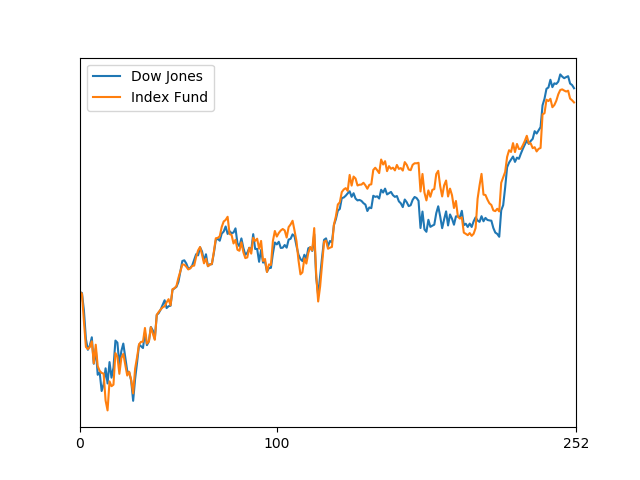

In [18]:
%gams_pull -d fund error
fig, ax = plt.subplots()
index.plot(y="value", ax=ax, xticks=[0, trainingDays, len(date)], yticks=[], label="Dow Jones")
fund.plot(y="value", ax=ax, xticks=[0, trainingDays, len(date)], yticks=[], label="Index Fund")

<IPython.core.display.Javascript object>


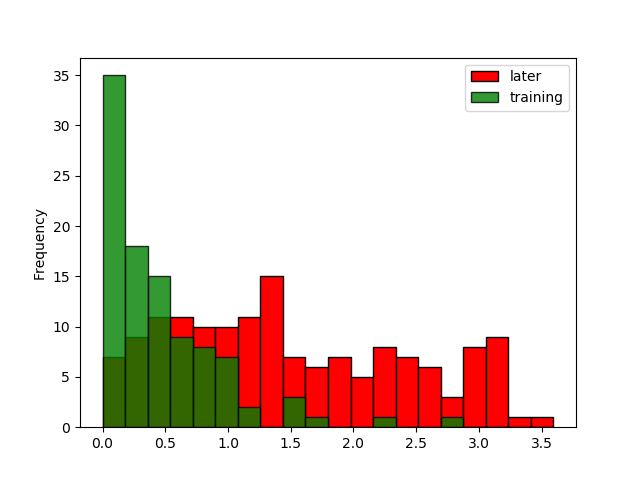

In [19]:
maxError = error['value'].max()
fig, ax = plt.subplots(edgecolor='black')
error[trainingDays:].plot.hist(x='date', y='value', ax=ax, bins=20, range=(0, maxError), label='later', color='red', edgecolor='black')
error[:trainingDays].plot.hist(x='date', y='value', ax=ax, bins=20, range=(0, maxError), label='training', color='green', alpha=0.8, edgecolor='black')